In this notebook, we will use machine learning to predict gas mileage of cars, using the well-known MT Cars dataset.
We will use some advanced metrics and techniques to provide prediction intervals and assess undue influence on the model.



First, we need to import the necessary libraries and data

In [628]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split
import seaborn as sns
from statsmodels.formula.api import ols

In [629]:
cars = pd.read_csv("./Documents/Python Data/mtcars")

It's important to do some basic exploratory analysis on the data, to become familiar with some of its properties, and possible quirks. Seaborn's strip plot is a great choice, for both quantitative data and categorical, ordinal data.

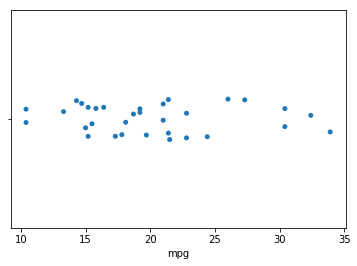

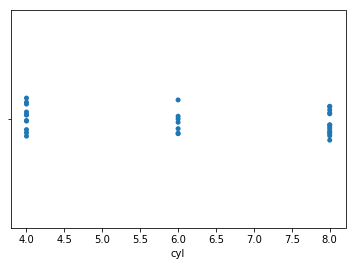

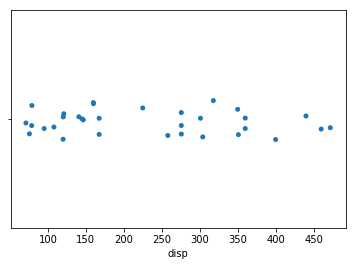

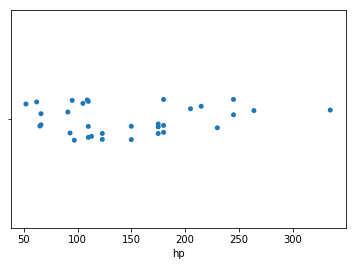

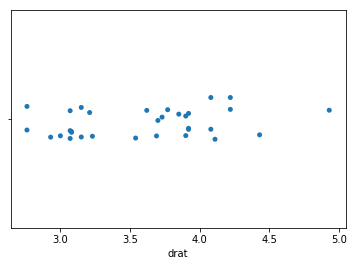

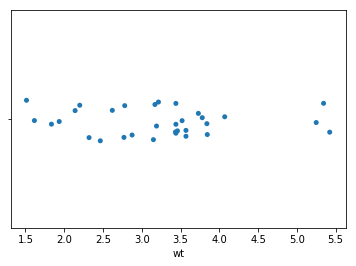

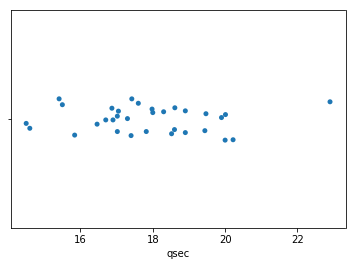

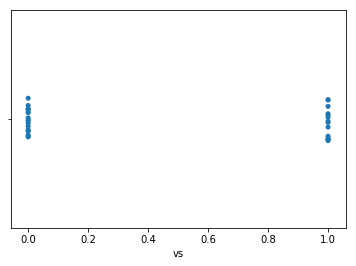

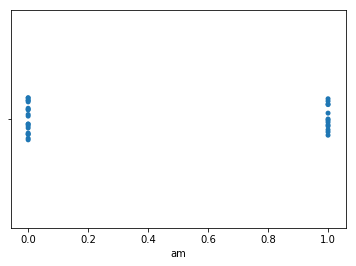

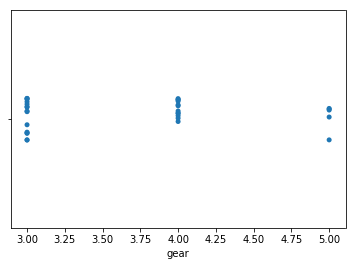

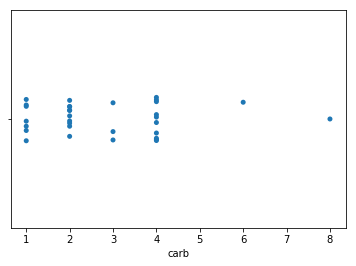

In [1148]:
for i in cars.columns[1:]:
    sns.stripplot(x=cars.loc[:,i])
    plt.show()

We see that miles per gallon, displacement, horsepower, drat(rear axle ration), weight and qsec (0.25 mile time) are all continuous quantitative variables, while the rest are either categorical variables or discrete quantitative variables.

We see that drat, horsepower,qsec and carburators all have unusual observations. Are these all from the same car?

In [1163]:
print("drat outlier:",cars.sort_values(by='drat',ascending = False).iloc[0][0])
print("hp outlier:",cars.sort_values(by='hp',ascending = False).iloc[0][0])
print("carb outlier:",cars.sort_values(by='carb',ascending = False).iloc[0][0])
print("qsec outlier:",cars.sort_values(by='qsec',ascending = False).iloc[0][0])

drat outlier: Honda Civic
hp outlier: Maserati Bora
carb outlier: Maserati Bora
qsec outlier: Merc 230


The unusual observations above do not all belong to the same car.

We will return to the concern that any of these observations may exert undue influence on our model.

We will fit a multiple regression model to the data. The dataset is small enough, 
(32 observations, 10 prediction variables) that we can fit all possible combinations of predictor variables,
and select the model with the best adjusted R squared. We define some helper functions to allow us to select the
best model.

In [631]:
def zero(k):
    """returns k zeros to add to the beginning of the binary representation"""
    z = []
    for i in range(k):
        z.append(0)
    return(z)

def conv(n,digit = 2):
    """returns binary representation of positive integer"""
    max = divide(n,digit = digit)
    result = []
    for i in reversed(range(max)):
        if (n >= digit**i):
            n = n%(digit**i)
            result.append(1)
        else:
            result.append(0)
    return (result)


def perm(n, excludeAllZero = True):
    """Uses conv to permute 0 and 1 for n choices"""
    my_list = []
    for i in range(2**n):
        add = conv(i)
        str_len = len(add)
        zeros = zero(n-str_len)
        add_total = zeros + add
        if(excludeAllZero):
            
            if (np.sum(add_total) != 0):
                my_list.append(add_total)
        else:
            my_list.append(add_total)
    return(my_list)

def get(n):
    """Uses perm() to create list of lists for all possibilities of regressors"""
    old = perm(n)
    new = old[:]
    for i in range(len(old)):
        for j in range(len(old[0])):
            if (old[i][j] == 1):
                new[i][j] = j+1
    
    newest = []
    for i in range(len(new)):
        newest.append([])
        for j in range(len(new[0])):
            if (new[i][j] != 0):
                newest[i].append(new[i][j]-1)
        
    return(newest)
            

We now define a function to find the best combination of predictor variables for our regression.

In [1173]:
def my_lm(X,y):
    """Uses get() to find best regressors in terms of adj R^2. Returns best regressors."""
    best_adj = 0
    ind = get(len(X.iloc[0])) #obtain all possible combinations of predictor variables
    for i in range(len(ind)): 
        lm = LinearRegression() 
        lm.fit(X.iloc[:,ind[i]],y) # for each combination, fit a linear regression model.
        score = lm.score(X.iloc[:,ind[i]],y)
        adj = 1 - ((1-score)*(len(y)-1)/(len(y)-1-len(ind[i]))) #Obtain adjusted R squared
        if (adj > best_adj): 
            best_adj = adj
            formula = ind[i] #Select best combination
    
    print(best_adj)
    print(formula)
    print("best predictors are: ",list(X.columns[formula]))
    return (formula)

We now split our data into predictor and response variables.

In [ ]:
X = cars.iloc[:,2:12]
y = cars.iloc[:,1]

We then split our data into training and test sets, for validation.

In [637]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state=19)

0.8180941376789094
[3, 4, 5, 7, 9]


We find the best combination of predictor variables and fit the best model to the training data, using the best predictors.

In [1174]:
coef = my_lm(X_train,y_train)

0.8180941376789094
[3, 4, 5, 7, 9]
best predictors are:  ['drat', 'wt', 'qsec', 'am', 'carb']


The best predictors are displacement, weight, qsec, automatic and carburators,
which yield an adjusted R squared on the training set of 0.818.

In [1193]:
new_lm = LinearRegression()
new_lm.fit(X_train.iloc[:,coef],y_train)
print(new_lm.coef_)

[ 1.95538512 -2.27535866  1.04071223  3.8437995  -0.73581929]


Before, we analyze our model too much, let's validate the assumptions underlying the theoretical foundations of linear regression. 

A useful mnemonic to remember the four key assumptions is LINE:
L - Linearity
I - Independence of Residuals
N - Normality of Residuals
E - Constant Error Variance

We will plot the residuals of our model against each predictor variable and check for patterns, dependence and 
changing variance.

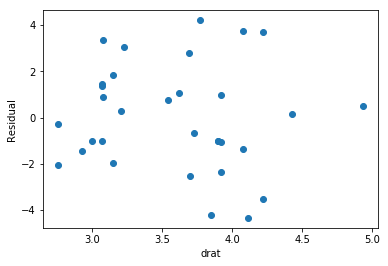

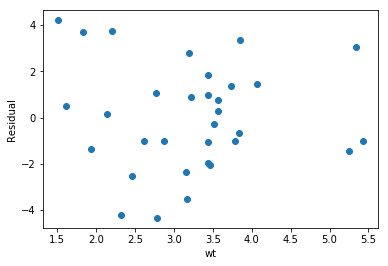

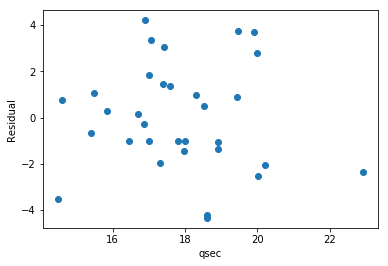

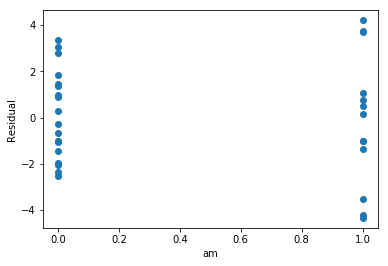

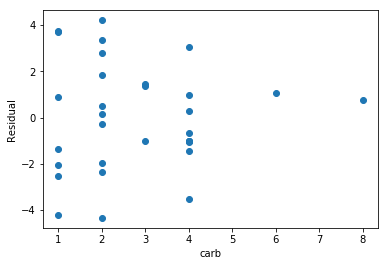

In [1182]:
predictions = new_lm.predict(X.iloc[:,coef])

residuals = y-predictions

for i in coef:
    plt.plot(X.iloc[:,i],residuals,linestyle='',marker='o')
    plt.xlabel(X.columns[i])
    plt.ylabel("Residual")
    plt.show()

We also plot residuals against fits.

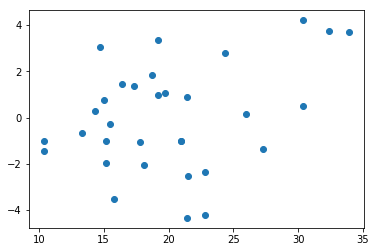

In [1184]:
plt.plot(y,residuals,linestyle = '',marker='o')
plt.show()

In the above plots, we do not see any systematic trend which would indicate non-linearity. Nor do we see clear evidence
of dependence of residuals or changing variance, known as heteroskedasticity.

We now provide a qq plot of residuals to test for normality.

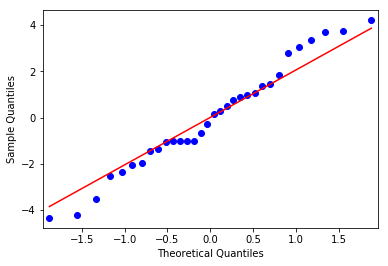

In [1186]:
sm.qqplot(residuals,line='q')
plt.show()

In [ ]:
The above qq plot is not perfect but seems acceptable. We now use two formal statistical tests for normality, namely 
the Anderson-Darling test and the Shapiro-Wilk test.

In [1190]:
print(stats.anderson(residuals))
print(stats.shapiro(residuals))

AndersonResult(statistic=0.25181222231415745, critical_values=array([0.523, 0.596, 0.715, 0.834, 0.992]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
(0.9729686379432678, 0.5850412845611572)


Both tests suggest that we should fail to reject the null hypothesis of normality.

Now that all four assumptions have been verified. Let's analyze the model, and make some predictions!

(1.95538512 -2.27535866  1.04071223  3.8437995  -0.73581929) are our coefficients and 
('drat', 'wt', 'qsec', 'am', 'carb') are our predictor variables. 

This means that automatic cars get 3.84 miles more per gallon than manual cars. Increases in the weight of the car and number of carburators are both associated with less fuel efficiency, as expected,while increases in the rear axle ratio  and qsec(0.25 mile time) of the car are associated with an increase in fuel efficiency. This is intuitive. Cars with faster accelerations have lower qsec and are likely less fuel efficient.

While the intercept of the model is 2.3018896740663237, this has very little practical meaning as factors such as car weight cannot be 0.



We noted above that there are some suprising values for certain predictor variables. 
To assess whether they, or other data points, are asserting undue influence on our model,
we use a measure called Cook's Distance. Any data point registering a Cook's Distance of 
over 0.5 warrants further investigation.

In [1200]:
m = ols('mpg~disp+hp+drat+qsec+am',cars,).fit()
infl = m.get_influence()
sm_fr = infl.summary_frame()
pd.DataFrame(sm_fr.cooks_d)

,cooks_d
0,0.041409
1,0.033520
2,0.033923
3,0.009701
4,0.026613
5,0.024132
6,0.011434
7,0.004496
8,0.012032
9,0.011916


No data points register Cook's distances higher than 0.13. This indicates that we need not be concerned about any
data point unduly influencing our model.

To obtain a measure of how well our model generalizes to out of sample data, we use predicted R squared, which measures 
the amount of variance explained in each data point, when it is the only data point left out of the fitting of the model. 
This is equivalent to leave-one-out cross validation.

We define a  function to calculate predicted R squared.

In [ ]:
def Calc_R2_pred(X,y,plot=False)  : 
    """Calculate R^2 pred for best linear model"""
    predictions=[]
    for i in range(len(X.iloc[:,1])):
        boolean = [True] * len(X.iloc[:,1])
        boolean[i] = False
        new_lm = LinearRegression()
        new_lm.fit(X.iloc[boolean],y.iloc[boolean])
        predictions.extend(new_lm.predict(np.array(X.iloc[i]).reshape(1,-1)))
    PRESS = np.sum((predictions-y)**2)
    print("PRESS:",PRESS)
    SST = np.sum((np.mean(y)-y)**2)
    R2_Pred = 1-PRESS/SST
    print("R2 Pred:", R2_Pred)
    if(plot):
        plt.plot(y.index,[np.mean(y)]*len(y.index),linestyle='',marker='o',color="red",label='Mean')
        plt.plot(y.index,predictions,linestyle='',marker='o',color="lightgreen",label="Prediction")
        plt.plot(y.index,y,linestyle='',marker='o',color="black",label="Actual")
        plt.legend()
    return(R2_Pred)

In [1194]:
Calc_R2_pred(X.iloc[:,coef],y)

PRESS: 237.27237765969053
R2 Pred: 0.7892873582087868


0.7892873582087868

78.9% of the variation of our left-out data points is explained by the model. This is a very positive result.

Next, we return to our predictions, of both the training and test data. 
Since our LINE assumptions are reasonable, we can use statistical theory to create 95% prediction intervals around 
our predictions. We define a function to calculate the standard errors required to construct our prediction intervals. First, we calculate the mean squared error of our regression, using both the training

In [1207]:
def MSE(res,p):
    """Returns MSE of regression"""
    SSE = 0
    for i in res:
        SSE += i**2
    MSE = SSE/(len(res)-p)
    return(MSE)

mse = MSE(res = residuals,p=len(coef)+1)

X_pert = X.iloc[:,coef]

In [1204]:
def create_se(X,mse,conf = False):
    """Returns confidence intervals for each point. Still needs to be multiplied by t value If conf = False, returns
    prediction intervals"""
    inv = np.linalg.inv(np.matmul(np.transpose(X_pert),X_pert))
    se = []
    for i in range(len(X.iloc[:,0])):
        se.append(np.matmul(np.matmul(X_pert.loc[i],inv),np.transpose(X_pert.loc[i])))
    se_array = np.array(se)*mse
    se_final = np.sqrt(se_array)
    if(conf):
        return(se_final)
    else:
        pred = np.sqrt(mse + (se_final**2))
        return(pred)

In [1208]:
se = create_se(X_pert,mse)


To obtain 95% prediction intervals, we multiply the appropriate our standard errors by the appropriate t-values.

In [ ]:
t = abs(stats.t.ppf(0.025,df=(len(X_train.iloc[:,1]-(len(coef)+1)))))
margin = se*t

We are finally ready to assess the predictions of our model, on both the training and test sets.

We plot the actual fuel efficiency values against our predictions, with 95% prediction intervals.
The bold elements are from the test set, while the faded elements are from the training set.

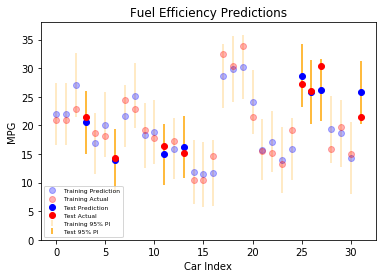

In [1202]:
plt.errorbar(y_train.index,predictions[y_train.index],yerr=margin[y_train.index],linestyle = '',color="orange",alpha=0.3,label="Training 95% PI")
plt.ylim((0,38))
plt.plot(y_train.index,predictions[y_train.index],linestyle = '',marker = 'o',color='blue',alpha = 0.3,label='Training Prediction')
plt.plot(y_train.index,y[y_train.index],linestyle='',marker = 'o',color="red",label = 'Training Actual',alpha=0.3)
plt.errorbar(y_test.index,predictions[y_test.index],yerr=margin[y_test.index],linestyle = '',color="orange",label="Test 95% PI")
plt.plot(y_test.index,predictions[y_test.index],linestyle = '',marker = 'o',color='blue',label='Test Prediction')
plt.plot(y_test.index,y[y_test.index],linestyle='',marker = 'o',color="red",label = 'Test Actual')
plt.legend(loc='lower left',prop={'size': 6})
plt.xlabel('Car Index')
plt.ylabel('MPG')
plt.title('Fuel Efficiency Predictions')
plt.show()